In [1]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [2]:
#import necessary libraries
import os
import IPython
import librosa as lr
import numpy as np
from datetime import datetime
from packaging import version
import tensorboard
import keras
from keras import layers
from keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
from librosa import display
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Flatten,Dense,Activation,Conv2DTranspose
import time
from sklearn import preprocessing

#LOG_DIR = f'{int(time.time())}'

path = 'C:/Users/erikv/Desktop/IP/samples/' #path where the samples are stored'''
dirs = os.listdir(path) #open the directory using os library'''

def rosaspec(sound, NFFT): #defined functions for extracting the spectogram of a sound wave'''
    sound = np.concatenate((np.zeros(int(NFFT/2)),sound,np.zeros(int(NFFT/2))))
    spec_c = lr.stft(sound, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    return np.concatenate((np.expand_dims(np.real(spec_c),2),np.expand_dims(np.imag(spec_c),2)),axis=2)

def irosaspec(spec,NFFT): #defined function for extracting a soundwave from a spectogram'''
    spec_c = spec[:,:,0].squeeze() + 1j* spec[:,:,1].squeeze()
    return lr.istft(spec_c, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)[int(NFFT/2):-int(NFFT/2)]

In [3]:
NFFT =  int(1021/2) #selection of the NFFT, allows the modification of the sie of 2nd array dimension'''

batchsize = len(dirs) #selection of the batch size'''
testsize = int(0.2*batchsize) #selection of the test batch file'''

yoriginal1,sroriginal1 = lr.load(path+dirs[35],sr=4*8150) #open the audio file (in this case the 
                                                         #test one) using the librosa library'''
yoriginal1 = yoriginal1[0:int(len(yoriginal1)/2)] #cropping of the loaded file to half the length for testing purposes'''
#originalspect = lr.stft(yoriginal1, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
asignal = np.array([rosaspec(yoriginal1,NFFT)]) #spectogram extraction from the file'''
audio = asignal#/asignal.max() #normalized values to be between 0 and 1
test= audio


print (test.shape,test.max())

(1, 256, 256, 2) 50.64573738423506


In [4]:
IPython.display.display(IPython.display.Audio(yoriginal1,rate = sroriginal1)) #check if the audio has been correctly loaded

In [5]:
processed = np.load('processed.npy')

In [6]:
print(processed.shape)

(4096, 256, 256, 2)


In [7]:
xtrain = processed

In [8]:
device = 'cuda'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) #check if keras is using GPU optimization
if test[0,20,20,0] == xtrain[35,20,20,0]: #if these two numbers are the same the files are coincident and correct loading
    print ('--------------loading correct--------------')
else:
    print('--------------loading failed. check coordinates--------------') 

Num GPUs Available:  1
--------------loading correct--------------


In [9]:
#the autoencoder is composed of 4 encoding layers and 4 decoding layers

encoder_input = keras.Input(shape=(256, 256, 2), name="original audio")
x = layers.BatchNormalization()(encoder_input)
x = layers.Conv2D(4, 3, activation="relu",padding='same')(x)
x = layers.Conv2D(4, 3, activation="relu",padding='same',strides=(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(8, 3, activation="relu",padding='same')(x)
x = layers.Conv2D(8, 3, activation="relu",padding='same',strides=(2,2))(x)
x = layers.Conv2D(16, 3, activation="relu",padding='same')(x)
x = layers.Conv2D(16, 3, activation="relu",padding='same',strides=(2,2))(x)
x = layers.Conv2D(16, 3, activation="relu",padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 3, activation="relu",padding='same',strides=(2,2))(x)
x = layers.Conv2D(32, 3, activation=None,padding='same')(x)
encoder_output = layers.Flatten()(x) #the file is reduced to 8192

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(8192), name="encoded audio")
x = layers.Reshape((16,16,32))(decoder_input)
x = layers.Conv2DTranspose(32, 3, activation="relu",padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation="relu",padding='same',strides=(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(16, 3, activation="relu",padding='same')(x)
x = layers.Conv2DTranspose(16, 3, activation="relu",padding='same',strides=(2,2))(x)
x = layers.Conv2DTranspose(8, 3, activation="relu",padding='same')(x)
x = layers.Conv2DTranspose(8, 3, activation="relu",padding='same',strides=(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(4, 3, activation="relu",padding='same')(x)
x = layers.Conv2DTranspose(4, 3, activation="relu",padding='same',strides=(2,2))(x)
decoder_output = layers.Conv2DTranspose(2, 3, activation=None,padding='same')(x) #this last layer does not have an activation method

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(256, 256, 2), name="input")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()



Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original audio (InputLayer)  [(None, 256, 256, 2)]     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 2)       8         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 4)       76        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 4)       148       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 4)       16        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 8)       296       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 8)         584 

In [10]:
%reload_ext tensorboard
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

In [11]:
autoencoder.compile(optimizer='adam', 
                  loss='mean_squared_error') #the autoencoder is optimizwed using adam and the loss 
                                                              #and metrics are mean logarithmic squared error
autoencoder.fit(xtrain,xtrain,
                epochs=100,
                batch_size=20,
                shuffle=True,
                validation_split=0.2,
                callbacks = [tensorboard_callback]) #it is trained using a 20% validations. So from the 100 files batch, 80 are for 
                                      #training and 20 are for validation purposes

Epoch 1/100
164/164 [==============================] - 48s 191ms/step - loss: 4.2282 - val_loss: 8.0311
Epoch 2/100
164/164 [==============================] - 25s 154ms/step - loss: 4.1062 - val_loss: 7.9099
Epoch 3/100
164/164 [==============================] - 26s 159ms/step - loss: 4.1162 - val_loss: 7.4434
Epoch 4/100
164/164 [==============================] - 27s 167ms/step - loss: 4.0883 - val_loss: 7.4590
Epoch 5/100
164/164 [==============================] - 27s 165ms/step - loss: 4.0910 - val_loss: 7.3672
Epoch 6/100
164/164 [==============================] - 26s 160ms/step - loss: 4.0900 - val_loss: 7.3109
Epoch 7/100
164/164 [==============================] - 26s 157ms/step - loss: 4.0846 - val_loss: 7.2405
Epoch 8/100
164/164 [==============================] - 25s 151ms/step - loss: 4.0859 - val_loss: 7.3408
Epoch 9/100
164/164 [==============================] - 26s 158ms/step - loss: 4.0881 - val_loss: 7.2575
Epoch 10/100
164/164 [==============================] - 26s 159m

164/164 [==============================] - 93s 571ms/step - loss: 3.6438 - val_loss: 6.4327
Epoch 80/100
164/164 [==============================] - 32s 193ms/step - loss: 3.6241 - val_loss: 6.3962
Epoch 81/100
164/164 [==============================] - 28s 174ms/step - loss: 3.6183 - val_loss: 6.4064
Epoch 82/100
164/164 [==============================] - 27s 165ms/step - loss: 3.6171 - val_loss: 6.3748
Epoch 83/100
164/164 [==============================] - 43s 265ms/step - loss: 3.5987 - val_loss: 6.4156
Epoch 84/100
164/164 [==============================] - 53s 328ms/step - loss: 3.6168 - val_loss: 6.3712
Epoch 85/100
164/164 [==============================] - 28s 172ms/step - loss: 3.5931 - val_loss: 6.3356
Epoch 86/100
164/164 [==============================] - 29s 175ms/step - loss: 3.5877 - val_loss: 6.3535
Epoch 87/100
164/164 [==============================] - 27s 165ms/step - loss: 3.5801 - val_loss: 6.3203
Epoch 88/100
164/164 [==============================] - 28s 169ms/st

In [12]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4424), started 4 days, 0:34:20 ago. (Use '!kill 4424' to kill it.)

In [13]:
autoencoder.save("autoencoder_v24")
#encoder.save("encoder_v23")

INFO:tensorflow:Assets written to: autoencoder_v24\assets


In [23]:
#autoencoder = tf.keras.models.load_model('autoencoder_v23')
#encoder =  tf.keras.models.load_model('encoder_v23')

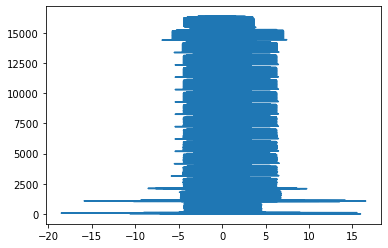

In [14]:
encoded_vector = encoder(np.array([xtrain[1]]))
t = np.linspace(0,16384,8192)
plt.plot(encoded_vector[0],t)

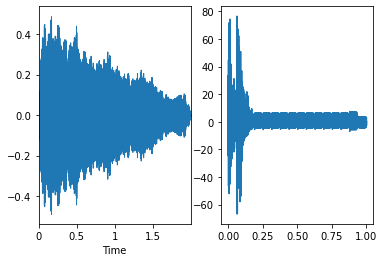

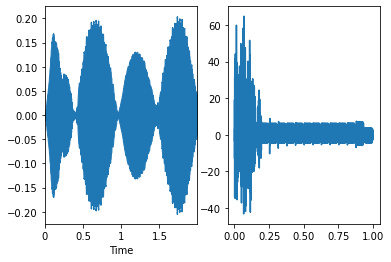

In [15]:
t = np.linspace(0,1,8192)
for i in [123,556]:
    encoded_vector = encoder(np.array([xtrain[i]]))
    decoded_array = np.array(autoencoder(np.array([xtrain[i]])))
    decoded_audio = irosaspec(decoded_array[0],NFFT)
    original = irosaspec(xtrain[i],NFFT)
    plt.figure()
    plt.subplot(1, 2, 2)
    plt.plot(t,encoded_vector[0])
    plt.subplot(1, 2, 1) 
    lr.display.waveplot(y=decoded_audio,sr=sroriginal1)
    IPython.display.display(IPython.display.Audio(decoded_audio,rate = sroriginal1))
    IPython.display.display(IPython.display.Audio(original,rate = sroriginal1))

(1, 256, 256, 2) (65025,) (65025,)
0.0063180216 0.0014211687957867982


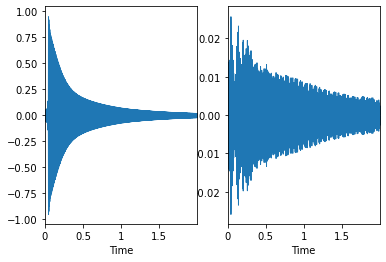

In [11]:
decoded_array = np.array(autoencoder(test)) #a sample file is runned through the autoencoder
decoded_audio = irosaspec(decoded_array[0],NFFT) #the output array is transformed into audio using the reverse spectogram fnct.

deprobe = irosaspec(xtrain[35],NFFT) #this is just the sample file runned directly from the processed array NOT the autoenc.

#noisy = yoriginal+np.random.normal(0,0.01,64000)
#ennoisy = rosaspec(noisy, NFFT)
#denoisy = irosaspec(ennoisy,NFFT)
print(decoded_array.shape,decoded_audio.shape,deprobe.shape)
print(decoded_audio[400],deprobe[400])
plt.figure()
plt.subplot(1, 2, 2) 
lr.display.waveplot(y=decoded_audio,sr=sroriginal1)
plt.subplot(1, 2, 1) 
lr.display.waveplot(y=yoriginal1,sr=sroriginal1)
plt.show()

#IPython.display.display(IPython.display.Audio(file))
IPython.display.display(IPython.display.Audio(deprobe,rate = sroriginal1))
#IPython.display.display(IPython.display.Audio(noisy,rate=sroriginal))
#IPython.display.display(IPython.display.Audio(denoisy,rate=sroriginal))
IPython.display.display(IPython.display.Audio(decoded_audio,rate=sroriginal1))



In [46]:
encoded_array = encoder(test)
encoded_array

<tf.Tensor: shape=(1, 80, 80, 64), dtype=float32, numpy=
array([[[[0.00000000e+00, 0.00000000e+00, 8.88219833e+00, ...,
          3.21911931e+00, 2.09728851e+01, 6.77881861e+00],
         [8.29132855e-01, 1.42069111e+01, 0.00000000e+00, ...,
          2.62937050e+01, 1.10293665e+01, 1.40658188e+01],
         [1.10255928e+01, 1.48785734e+01, 0.00000000e+00, ...,
          3.30265880e+00, 0.00000000e+00, 5.44991732e+00],
         ...,
         [0.00000000e+00, 1.78576875e+00, 3.59359458e-02, ...,
          2.17136931e+00, 1.84202945e+00, 2.03786993e+00],
         [0.00000000e+00, 1.18344620e-01, 5.13677645e+00, ...,
          1.31172073e+00, 1.50830758e+00, 0.00000000e+00],
         [0.00000000e+00, 2.98698592e+00, 6.61337996e+00, ...,
          0.00000000e+00, 0.00000000e+00, 2.77210236e+00]],

        [[7.20693398e+00, 3.28745055e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 2.29155040e+00],
         [4.32349491e+00, 4.35678661e-03, 0.00000000e+00, ...,
          

In [14]:
print(decoded_array.shape)

(100, 256, 256, 2)


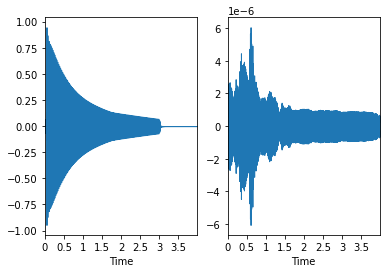

In [58]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Setting standard filter requirements.
order = 6
fs = 30.0       
cutoff = 8

b, a = butter_lowpass(cutoff, fs, order)

filtered1 = butter_lowpass_filter(yoriginal1, cutoff, fs, order)
filtered = butter_lowpass_filter(decoded_audio, cutoff, fs, order)
plt.figure()
plt.subplot(1, 2, 2) 
lr.display.waveplot(y=filtered,sr=sroriginal)
plt.subplot(1, 2, 1) 
lr.display.waveplot(y=yoriginal1,sr=sroriginal)
plt.show()

IPython.display.display(IPython.display.Audio(yoriginal1,rate=sroriginal))
IPython.display.display(IPython.display.Audio(filtered,rate=sroriginal))

In [102]:
audio.max(), audio.min()

(1.0, -0.856759766190995)

In [89]:
print(yoriginal.shape)
print(enprobe.shape)
print(deprobe.shape)
print(decoded_array.shape)
print(decoded_audio.shape)



(64000,)
(504, 128, 2)
(63881,)
(504, 128, 2)
(63881,)


(1.0, -0.7587283885818327)

In [81]:
i = 2
j = 4
while i<25600/2:
    NFFT = i
    file = 'C:/Users/erikv/Desktop/IP/samples/bass_electronic_027-056-050.wav'

    yoriginal,sroriginal = lr.load(file,sr=None)
    orginalspect = lr.stft(yoriginal, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    audio = np.array([rosaspec(yoriginal,NFFT)])

    numbers = audio.shape
    x = numbers[1]
    y = numbers[2]
    if x%j == 0 and y%j == 0:
            print (i)
    i=i+2

110
126
134
166
174
182
254
286
294
302
334
382
406
422
478
486
494
518
526
534
582
606
630
654
670
766
782
822
846
870
894
918
942
974
1006
1038
1070
1110
1150
1190
1238
1286
1334
1342
1398
1406
1462
1470
1526
1534
1542
1606
1614


KeyboardInterrupt: 

<IPython.core.display.Javascript object>